# Reconstruction of Reflectance Spectra
### An example of dimensionality reduction using Principal Component Analysis (PCA)

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from pca_functions import *

tol = 1e-6

#### Loading Raw Data
Read in CSV file of reflectance spectra for both types of beans recorded using a Fourier-Transform Infrared Spectrometer (FTIR). The first row in the dataset contains the wavelengths at which the reflectances are measured. The first 29 rows are spectra from Arabica beans and the remaining are from Robusta.

In [35]:
# Read in spectra data
dataset = pd.read_csv("FTIR_Spectra_Coffee.csv", header = 0)
spectra = np.array(dataset)
wavelengths = list(dataset.columns.values)
wavelengths = [float(i) for i in wavelengths]

# Get shape of dataset
print("Shape of Spectra Dataset:", spectra.shape)

Shape of Spectra Dataset: (56, 286)


#### View Raw Data
Have a look at how each spectrum is related to wavelengths.

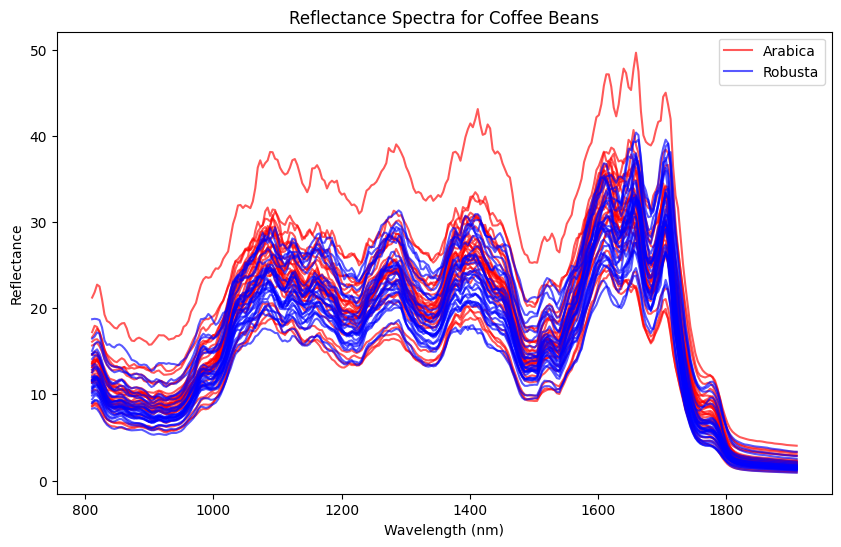

In [36]:
# Plot spectra data
rows = spectra.shape[0]
plt.figure(figsize = (10, 6))

for i in range(rows):
    if i < 29:  # Arabica
        plt.plot(wavelengths, spectra[i, :], label = 'Arabica' if i == 0 else "_nolegend_", color = 'red', alpha = 0.65)
    else:       # Robusta
        plt.plot(wavelengths, spectra[i, :], label = 'Robusta' if i == 29 else "_nolegend_", color = 'blue', alpha = 0.65)

plt.ylabel("Reflectance")
plt.xlabel("Wavelength (nm)")
plt.title("Reflectance Spectra for Coffee Beans")
plt.legend()
plt.show()

#### Prepare Data for PCA
Center the data as this is one of the key assumptions of PCA as such standardization ensures that all variables are transformed to the same scale. Also find the corresponding empirical covariance matrix to find eigenpairs later (we require a square matrix).

There are 56 samples of coffee beans measured across 286 wavelengths. Therefore, we expect the covariance matrix to be 286 by 286 (the number of dimensions in the dataset).

In [37]:
# Center data using pre-defined function
means, centered = center_matrix(spectra)

# Find empirical covariance matrix using pre-defined function
cov = covariance_matrix(centered)

# Get shape of covariance matrix
print("Shape of Covariance Matrix:", cov.shape)

Shape of Covariance Matrix: (286, 286)


#### Find Eigenpairs of Covariance Matrix
Calculate eigenvalues and eigenvectors numerically using the Power and Deflate methods. The number of eigenpairs is the minimum of the number of features and samples in the original dataset.

In [38]:
# Create initial vector to aid with matrix calculations
nvals = cov.shape[0]
init_vector = np.ones(nvals)

eigvals = []
eigvecs = []
init_mat = cov

# Loop through the spectra and find eigenpairs and store as arrays
npairs = min(rows, nvals)
for i in range(npairs):
    tempval, tempvec = power_method(init_mat, init_vector, tol)
    init_mat = deflate(init_mat, tempval, tempvec)
    eigvals.append(tempval)
    eigvecs.append(tempvec)

Let's check that the PCA class from scikit-learn's decomposition package returns the same outputs.

In [39]:
# Create PCA object and fit to centered data
pca = PCA(n_components = npairs)
pca.fit_transform(centered)

# Divide the eigenvalues obtained above by the output of the pca class to see if there is a constant scaling factor
eigvals / pca.explained_variance_ratio_

array([3.24577733e+03, 3.24577603e+03, 3.24577887e+03, 3.24577629e+03,
       3.24577671e+03, 3.24577784e+03, 3.24577892e+03, 3.24576979e+03,
       3.24577712e+03, 3.24578422e+03, 3.24577436e+03, 3.24577523e+03,
       3.24572616e+03, 3.24583106e+03, 3.24575976e+03, 3.24579113e+03,
       3.24577471e+03, 3.24577814e+03, 3.24574706e+03, 3.24578529e+03,
       3.24581194e+03, 3.24575145e+03, 3.24578990e+03, 3.24578298e+03,
       3.24576476e+03, 3.24579197e+03, 3.24577339e+03, 3.24575948e+03,
       3.24578103e+03, 3.24580218e+03, 3.24575580e+03, 3.24570637e+03,
       3.24584277e+03, 3.24580370e+03, 3.24574960e+03, 3.24580317e+03,
       3.24579168e+03, 3.24558222e+03, 3.24595748e+03, 3.24578769e+03,
       3.24575175e+03, 3.24577775e+03, 3.24579120e+03, 3.24579183e+03,
       3.24568291e+03, 3.24586820e+03, 3.24577512e+03, 3.24577654e+03,
       3.24579360e+03, 3.24577202e+03, 3.24577070e+03, 3.24576447e+03,
       3.24578811e+03, 3.24579651e+03, 3.24578028e+03, 5.23524800e+25])

The outputs match as there is a constant scaling factor - we can progress with our analysis. 

#### Examine Explained Variation Using Eigenpairs
Find how much of the original reflectance spectra is captured by its eigenpairs.

In [40]:
# Find total sum of eigenvalues
eigsum = sum(eigvals)

# Find cumulative sum of eigenvalues
eigratio = np.cumsum(eigvals) / eigsum
x = np.array(range(1, npairs + 1))

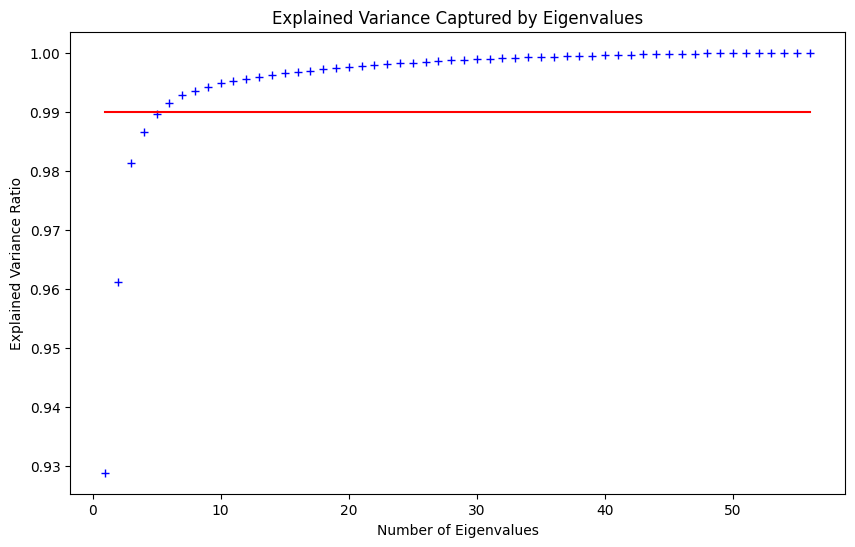

In [41]:
# Plot explained variance
plt.figure(figsize = (10, 6))
plt.plot(x, eigratio, "b+")
plt.plot(x, [0.99]*len(x), "r-")   # Plot horizontal line for comparison
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Number of Eigenvalues")
plt.title("Explained Variance Captured by Eigenvalues")
plt.show()

In [42]:
# Calculate percentage increase between consecutive points to find the limiting eigenvalue
grads = 100*np.diff(eigratio) / eigratio[:-1]
grads

array([3.47082057e+00, 2.10254354e+00, 5.26435558e-01, 3.09937417e-01,
       1.97286933e-01, 1.27496659e-01, 7.76406957e-02, 6.76483619e-02,
       5.94895264e-02, 4.28596719e-02, 3.57195786e-02, 3.17337793e-02,
       3.07753656e-02, 2.69444968e-02, 2.53333511e-02, 2.29482322e-02,
       2.11760601e-02, 1.93834113e-02, 1.87630288e-02, 1.80678083e-02,
       1.60352000e-02, 1.51991656e-02, 1.41751575e-02, 1.30734458e-02,
       1.24258113e-02, 1.13746613e-02, 1.05603613e-02, 1.01390404e-02,
       9.70362376e-03, 8.70275426e-03, 8.31403805e-03, 8.18780382e-03,
       7.88682466e-03, 7.17728412e-03, 6.92523606e-03, 6.43409306e-03,
       5.34828607e-03, 5.30506558e-03, 4.91117380e-03, 4.46752590e-03,
       4.28465185e-03, 4.11431780e-03, 3.88669185e-03, 3.42174090e-03,
       3.37145830e-03, 3.08936584e-03, 2.87423434e-03, 2.66732595e-03,
       2.10371915e-03, 1.89058946e-03, 1.73619330e-03, 1.65661181e-03,
       1.54295635e-03, 1.17325931e-03, 2.95483405e-07])

Based on the results above, we can use **6** eigenvalues to explain around **99.2%** of the variation in the original spectra.

#### Project Data into Eigenspace
Extract principal components and project the centered data into eigenspace. We must then find a pair of eigenvectors that allow us to best distinguish between the coffee beans.

In [43]:
# Extract 6 principal components
prin = np.array(eigvecs)[:6, :]

# Find projected matrix using matrix multiplication
projection = np.matmul(centered, prin.transpose())

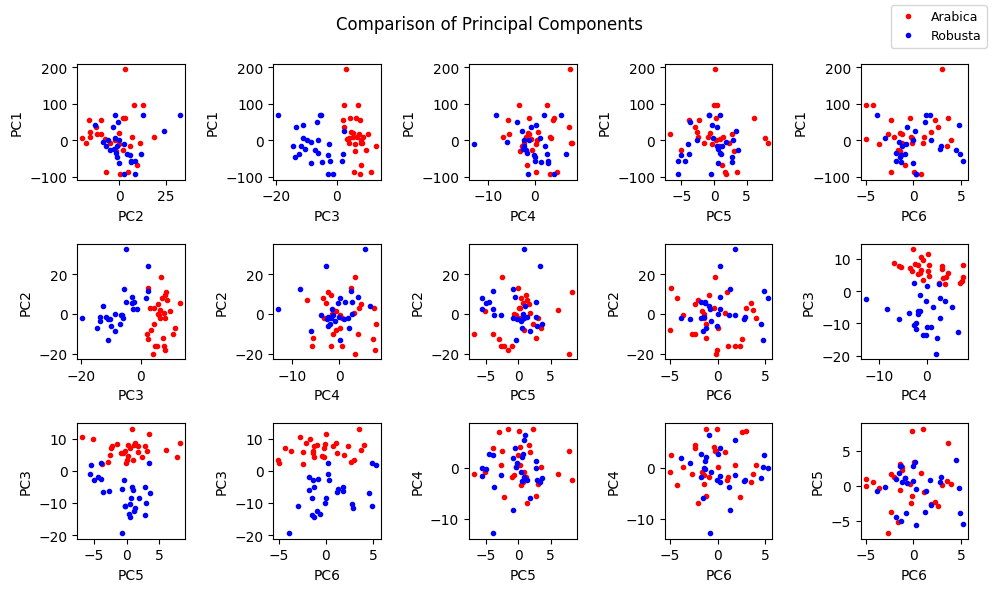

In [44]:
# Obtain all combinations of columns in the projection matrix 
fig = plt.figure(figsize = (10, 6))
k = 1
for i in range(0, 5):
    for j in range(i + 1, 6):
        ax = fig.add_subplot(3, 5, k)
        ax.plot(projection[:29, j], projection[0:29, i], "r.", label = "Arabica")           
        ax.plot(projection[29:rows, j], projection[29:rows, i], "b.", label = "Robusta")
        ax.set_ylabel("PC" + str(i + 1), size = 10)
        ax.set_xlabel("PC" + str(j + 1), size = 10)
        k += 1

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc = "upper right", prop = {"size": 9})
fig.suptitle("Comparison of Principal Components")
fig.tight_layout(pad = 1.5)
plt.show()

Third and fourth components (scatter plot 10) offer a good separation of coffee beans.

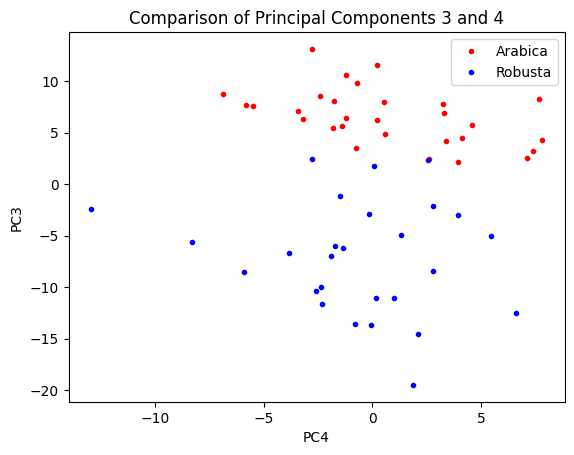

In [45]:
# Scatter plot 
plt.plot(projection[:29, 3], projection[:29, 2], "r.", label = "Arabica")
plt.plot(projection[29:, 3], projection[29:, 2], "b.", label = "Robusta")
plt.ylabel("PC3")
plt.xlabel("PC4")
plt.title("Comparison of Principal Components 3 and 4")
plt.legend()
plt.show()

#### Generate Reconstructed Spectra
Based on the projected matrix, reconstruct the original spectra using 6 principal components. Lets plot the original and reconstructed spectra for the 3rd sample of Arabica beans (row 3) and the 15th sample of Robusta beans (row 44).

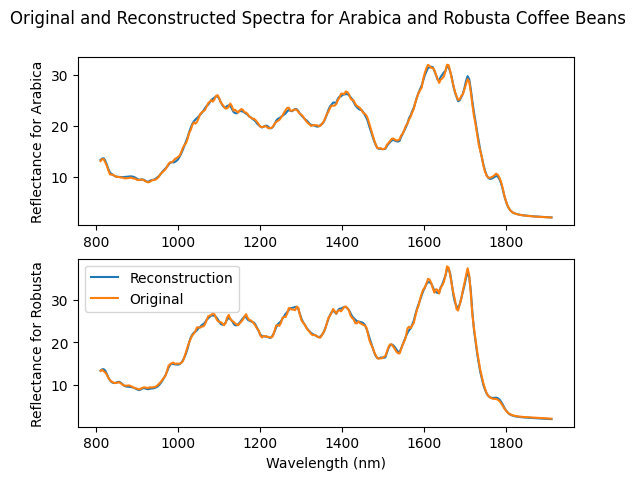

In [46]:
fig, axs = plt.subplots(2)
eigvecs = np.array(eigvecs)

# Arabica
sums = [0]*286
for i in range(0, 6):
    sums += projection[2, i] * eigvecs[i, 0:286]

# "Recenter" data to return to original scaling
recon_arab = sums + means
axs[0].plot(wavelengths, recon_arab, label = "Reconstruction")
axs[0].plot(wavelengths, spectra[2, :], label = "Original")
axs[0].set_ylabel("Reflectance for Arabica")

# Robusta
sums = [0]*286
for i in range(0, 6):
    sums += projection[43, i]*eigvecs[i, 0:286]

# "Recenter" data to return to original scaling
recon_rob = sums + means
axs[1].plot(wavelengths, recon_rob, label = "Reconstruction")
axs[1].plot(wavelengths, spectra[43, :], label = "Original")
axs[1].set_ylabel("Reflectance for Robusta")
axs[1].set_xlabel("Wavelength (nm)")
fig.suptitle("Original and Reconstructed Spectra for Arabica and Robusta Coffee Beans")
plt.legend()
plt.show()